### Analyze Sensitivity Results

In [1]:
import os
import traceback
import pandas as pd
res_dir = 'nb_hydr_static_v5_sssim_cali_exp_4_1'
cali_dir = 'cali_exp_4'
if not os.path.isdir(cali_dir):
    os.mkdir(cali_dir)
calibration_data_org = pd.read_csv('2020P2_calibration_data_30m.csv')
contents = os.listdir(res_dir)

In [13]:
import os
import pandas as pd
results = []
valid_contents = []

result_name = 'chw_sup_m.m_flow'
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)
for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    try:
        result_pd = pd.read_csv(result_file_path, header = None)
        results.append(result_pd.values[:, result_idx])
        valid_contents.append(content)
    except Exception:
        print(traceback.format_exc())
print(len(results))

Traceback (most recent call last):
  File "/tmp/ipykernel_2163164/1567848210.py", line 12, in <module>
    result_pd = pd.read_csv(result_file_path, header = None)
  File "/home/jjr/HydraulicCalibration/venv/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/jjr/HydraulicCalibration/venv/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 577, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/jjr/HydraulicCalibration/venv/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 1407, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/jjr/HydraulicCalibration/venv/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 1661, in _make_engine
    self.handles = get_handle(
  File "/home/jjr/HydraulicCalibration/venv/lib/python3.8/site-packages/pandas/io/common.py", line 859, in get_handle
    handle = open(
FileNotFoundE

In [3]:
import numpy as np
# get calibration true data
# since each run may only randomly select a subset of calibration data, so each run has different calibration true data
calibration_datas = []

for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'random_indices.csv'
    if os.path.isfile(res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'):
        print(result_file_path)
        try:
            indices_array = np.genfromtxt(result_file_path, delimiter=',')
            calibration_data_i = calibration_data_org.iloc[indices_array, :]
            calibration_datas.append(calibration_data_i)
        except:
            pass
    else:
        pass
print(len(calibration_datas))

nb_hydr_static_v5_sssim_cali_exp_4_1/run_98/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_96/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_465/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_109/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_27/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_268/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_184/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_45/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_427/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_42/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_199/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_517/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_43/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_116/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_211/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_247/r

In [4]:
# remove results with none
import numpy as np
val_idx = []
for i in range(len(results)):
    result_i = results[i]
    if np.isnan(result_i).sum() == 0:
        val_idx.append(i)
results_clean = [results[j] for j in val_idx]


val_idx_col = []
for i in range(np.array(results).shape[1]):
    result_i = np.array(results)[:, i]
    if np.isnan(result_i).sum() == 0:
        val_idx_col.append(i)
len(val_idx)

220

In [5]:
mbes = {}
fig, axs = plt.subplots(1, figsize = (20, 10))
for i in range(len(val_idx)):
    err_i = calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values - results_clean[i]
    axs.plot(err_i)
    mbes[i] = err_i.mean()
print(mbes)

NameError: name 'plt' is not defined

In [18]:
valid_contents[2]

'run_465'

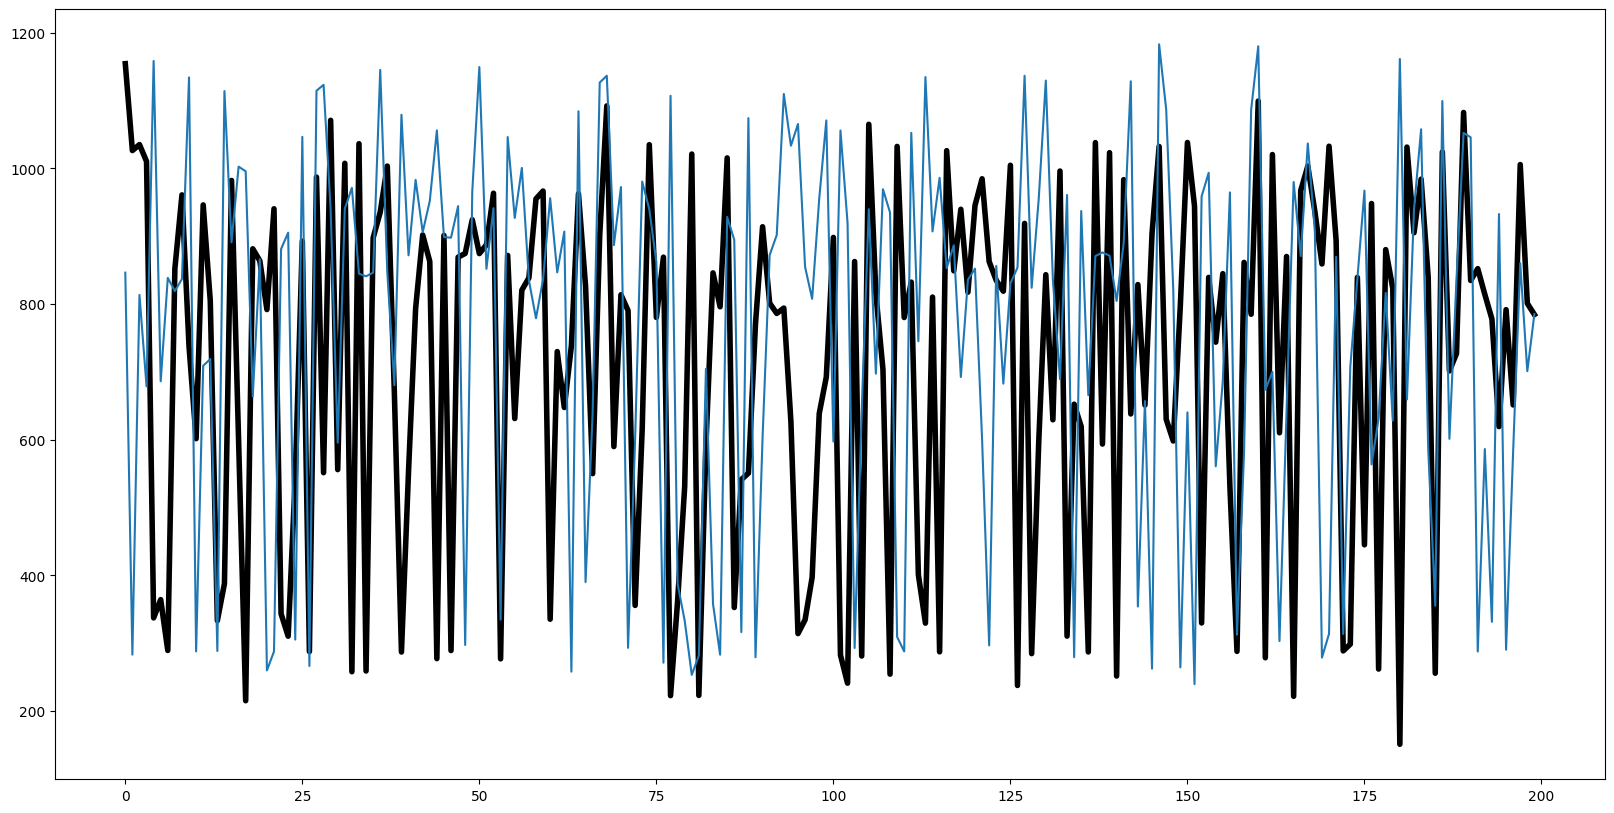

In [22]:
import matplotlib.pyplot as plt
import numpy as np
i = 5
fig, axs = plt.subplots(1, figsize = (20, 10))
axs.plot(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values,
         color = 'k', linewidth = 4, label = 'True')
mapes = []
cvrmses = []
result_this = results_clean[i]
axs.plot(result_this, label = 'run_{}'.format(i))
mape_i = 100*(abs(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))/\
             calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values).mean()
mapes.append(mape_i)
cvrmse_i = (((calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))**2).sum()/len(result_this))**0.5/\
            calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values.mean()
cvrmses.append(cvrmse_i)
    

In [75]:
def get_t(mo_path):
    chr_pipe_len = None
    chr_v_nom = None
    with open(mo_path) as file:
        lines = file.readlines()
        for line in lines:
            if 'parameter Real chiller_pipe_len=' in line:
                chr_pipe_len = float(line
                                     .split('parameter Real chiller_pipe_len=')[-1]
                                     .split('"m";')[0]
                                     .strip())
            if 'parameter Real chiller_v_nominal=' in line:
                chr_v_nom = float(line
                                     .split('parameter Real chiller_v_nominal=')[-1]
                                     .split('"m/s";')[0]
                                     .strip())
            if chr_pipe_len is not None and chr_v_nom is not None:
                break
    return chr_pipe_len, chr_v_nom
            

In [76]:
# prepare data files for calibration
mo_file_name = 'nb_hydr_static_v6.mo'
result_name = 'chw_sup_m.m_flow'
calibration_x_names = ['NB2_S_1_NYZ_sys_x_PcwOut_x','NB2_S_1_NYZ_sys_x_PcwIn_x',
             'NB2_S_1_NYZ_cwp_9_HzSPR_x','NB2_S_1_NYZ_cwp_10_HzSPR_x',
             'NB2_S_1_NYZ_cwp_11_HzSPR_x','NB2_S_1_NYZ_cwp_12_HzSPR_x']
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)

for i in range(len(contents)):
    content = contents[i]
    # get the corresponding calibration data
    calibration_x = calibration_datas[i][calibration_x_names].values

    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    result_pd = pd.read_csv(result_file_path, header = None)
    sim_y = result_pd.values[:, result_idx].reshape(-1, 1)
    cali_sim_data = np.concatenate((sim_y, calibration_x), axis = 1)
    mo_file_path = res_dir + os.sep + content\
                + os.sep + 'compilation'\
                + os.sep + mo_file_name
    chr_pipe_len, chr_v_nom = get_t(mo_file_path)
    sim_t = np.ones((sim_y.shape[0], 2)) * (chr_pipe_len, chr_v_nom)
    cali_sim_data = np.concatenate((cali_sim_data, sim_t), axis = 1)
    cali_sim_data = pd.DataFrame(cali_sim_data)
    column_names = ['m_flow_pred']
    column_names.extend(calibration_x_names)
    column_names.extend(['chiller_pipe_len', 'chiller_v_nominal'])
    cali_sim_data.columns = column_names
    cali_sim_data.to_csv(res_dir + os.sep + content + os.sep + 'cali_sim_data.csv', index=False)

In [77]:
# get all parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []

for content in contents:

    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    parameters.append(data_i.values[0, -2: ])            
parameters = np.array(parameters)
print(parameters[val_idx])

[[ 67.19904766   0.53745911]
 [ 32.86982558   2.17680067]
 [117.77318711   1.56817237]
 [114.68417015   0.61138035]
 [134.53761017   1.33266129]
 [ 65.79402565   0.72379439]
 [120.19344277   1.48527544]
 [ 82.91773818   2.73770141]
 [ 27.6682452    1.40420156]
 [109.45661565   2.96953443]
 [ 80.43819617   2.2133112 ]
 [ 71.88508364   2.17220864]
 [ 85.15500327   2.11335009]
 [144.26822046   2.37752062]
 [ 50.9737072    2.65133386]
 [ 93.27161166   1.99887226]
 [ 20.96975971   2.01184791]
 [ 90.77967298   1.3862407 ]
 [ 60.85166365   2.61485716]
 [ 81.70774803   1.81408207]
 [112.37878393   2.21156512]
 [ 21.95891572   1.46624776]
 [ 58.35580599   0.81615194]
 [102.88749869   1.32146021]
 [146.3337956    1.92717821]
 [113.92396307   1.5984671 ]
 [123.72682776   1.70441955]
 [136.59997242   1.538177  ]
 [108.10117894   0.75102903]
 [ 34.59330096   0.87703769]
 [ 33.65023144   1.40938447]
 [103.18450349   2.17979859]
 [ 11.19460157   1.5590672 ]
 [137.80572952   0.9575927 ]
 [ 82.56880054

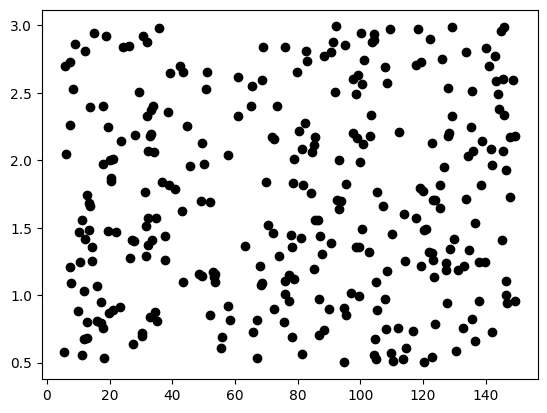

In [78]:
plt.scatter(parameters[:, 0], parameters[:, 1], color ='k')

In [79]:
# get a closer range for the parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []
narrowed_run_dirs = []
mape_thres = 100

for i in range(len(contents)):
    content = contents[i]
    y_true = calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values
    
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    y_pred_i = data_i['m_flow_pred'].values
    mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
    if mape_i <= mape_thres:
        parameters.append(data_i.values[0, -2: ])
        narrowed_run_dirs.append(res_dir + os.sep + content)
            
parameters = np.array(parameters)
print(len(narrowed_run_dirs))

/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(ab

276


/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()


In [83]:
# collect all cali_sim_data
cali_sim_data_all = None

for i in range(len(contents)):
    content = contents[i]
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    if (res_dir + os.sep + content) in narrowed_run_dirs:
        data_i = pd.read_csv(data_file_path)
        if cali_sim_data_all is None:
            cali_sim_data_all = data_i
        else:
            cali_sim_data_all = pd.concat([cali_sim_data_all, data_i],
                                  ignore_index = True)

In [84]:
cali_sim_data_all.shape

(55200, 9)

In [85]:
cali_sim_data_all.to_csv('{}/cali_sim_data_all.csv'.format(cali_dir),
                        index=False)

In [87]:
# Down sample
from BayesianCalibration.DownSampler import DownSampler
import pandas as pd
field_data_columns = ['NB2_S_x_NYZ_x_x_Fcw_x', 'NB2_S_1_NYZ_sys_x_PcwOut_x', 
                      'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_12_HzSPR_x']

cali_sim_data_path = './{}/cali_sim_data_all.csv'.format(cali_dir)
field_df = calibration_data_org[field_data_columns]

bins = 50
quality_thres_sim = 0.8
quality_thres_field = 0.8
dirichlet_prior = 0.5
sim_df = pd.read_csv(cali_sim_data_path)
d_sim = sim_df.values
d_field = field_df.values

ds_d_sim = DownSampler(d_sim, bins = bins, dirichlet_prior = dirichlet_prior)
(d_sim_down, d_sim_sp_hist) = ds_d_sim.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres_sim)
d_sim_down_df = pd.DataFrame(d_sim_down)
d_sim_down_df.columns = [list(sim_df.columns)]
d_sim_down_df.to_csv('./{}/cali_sim_data_down.csv'.format(cali_dir), index = False)

ds_d_field = DownSampler(d_field, bins = bins, dirichlet_prior = dirichlet_prior)
(d_field_down, d_field_sp_hist) = ds_d_field.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres_field)
d_field_down_df = pd.DataFrame(d_field_down)
d_field_down_df.columns = [field_data_columns]
d_field_down_df.to_csv('./{}/cali_field_data_down.csv'.format(cali_dir), index = False)

[2.43549117e-03 9.46129470e-03 1.62698053e-02 1.76822091e-02
 1.91670439e-02 2.00905387e-02 2.59393391e-02 2.78225441e-02
 3.02670892e-02 3.17881394e-02 3.24762336e-02 3.02308737e-02
 2.92349479e-02 3.07197827e-02 2.76776822e-02 2.59031236e-02
 2.60842010e-02 2.80760525e-02 2.71887732e-02 2.70982345e-02
 2.88003622e-02 2.86917157e-02 3.18786781e-02 2.86011770e-02
 3.01403350e-02 2.84563151e-02 2.71706655e-02 2.76595745e-02
 2.70258035e-02 2.78949751e-02 2.72974196e-02 2.79492983e-02
 2.50339520e-02 2.48166591e-02 2.25531915e-02 1.84427343e-02
 1.80805794e-02 1.71751924e-02 1.43322770e-02 1.04391127e-02
 7.55998189e-03 6.63648710e-03 3.79357175e-03 2.03712087e-03
 9.32548665e-04 5.16070620e-04 2.44454504e-04 8.14848348e-05
 1.17700317e-04 2.71616116e-05]
52
54
56
58
60
63
66
69
72
75
78
81
85
89
93
97
101
106
111
116
121
127
133
139
145
152
159
166
174
182
191
200
210
220
231
242
254
266
279
292
306
321
[0.00063105 0.00021035 0.00105175 0.00105175 0.00021035 0.00147244
 0.00231384 0.002